Project 4: Generative Adversarial Networks
======
In this project, you are expected to fill in the missing parts of a PyTorch implementation of the Deep Convolutional Generative Adversarial Network (DCGAN) [1] and test its performance on several datasets.<br>
Please **read the instructions carefully**. We provide reference outputs for most tasks and we will judge your solution based on your code as well as on the quality of your output and similarity to our results.

We will be using datasets with small images for this project, because high-resolution GANs take notoriously long to train.

**References:**

[1] [Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.](https://arxiv.org/abs/1511.06434)

[2] [MNIST dataset.](http://yann.lecun.com/exdb/mnist/)

[3] [FashionMNIST dataset.](https://github.com/zalandoresearch/fashion-mnist)

[4] [UTKFace dataset.](https://susanqq.github.io/UTKFace/)

## Assignment 4A: DCGAN

### Verify your PyTorch installation

In [0]:
import torch
import torchvision

# Print Basic Information
print('Torch', torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Torch 1.3.0+cu100
Device: cuda


In [0]:
#import statements
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torchsummary import summary
import numpy as np

### 1) Load and prepare the dataset (5 points)

Pick either _MNIST_ [2] or _FashionMNIST_ [3] as your dataset for this assignment. Both datasets contain grayscale images with a natural resolution of $28\times28$ pixels, have 10 classes and can be imported from `torchvision.datasets`.<br>
The color channels in the _MNIST_ as well as in _FashionMNIST_ dataset are stored inverted, ie with white content on a black background. This is because, per default, convolution layers in the network add zero-padding to the image, hence a black background works more naturally and yields better results during training.
We do, however, want to show our results with **black content** on a **white background**. To that end, **add appropriate functionality** in the plotting/visualization functions throughout this notebook to invert and clamp the image values (see below visualization).

<img src="./img/mnist_example.JPG" width="800">
<img src="./img/fashion_mnist_example.JPG" width="800">


Implement the data loading, create the necessary **data transforms** such that your training images have $32\times32$ pixels, and have a value range between $[-1, 1]$:

Consider whether you can implement some **data augmentation**, and if possible, do so.

In [0]:
#######################################################################################################
# TODO 1: Load dataset. Implement the necessary functions so your data has a resolution of 32x32 pixels
# and the values are normalized to a [-1, 1] range. 
# Consider whether you can implement some data augmentation, and if possible, do so.
#######################################################################################################
train_dataset = datasets.MNIST('./data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ]))

print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

0it [00:00, ?it/s]

9920512it [00:01, 8694805.36it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134792.84it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2316356.96it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51523.12it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Dataset length:  60000
Image size: torch.Size([1, 28, 28])
value range: [ -1.0 - 1.0 ]


#### Inspect the training data

**Visualize a few examples** from your training data.

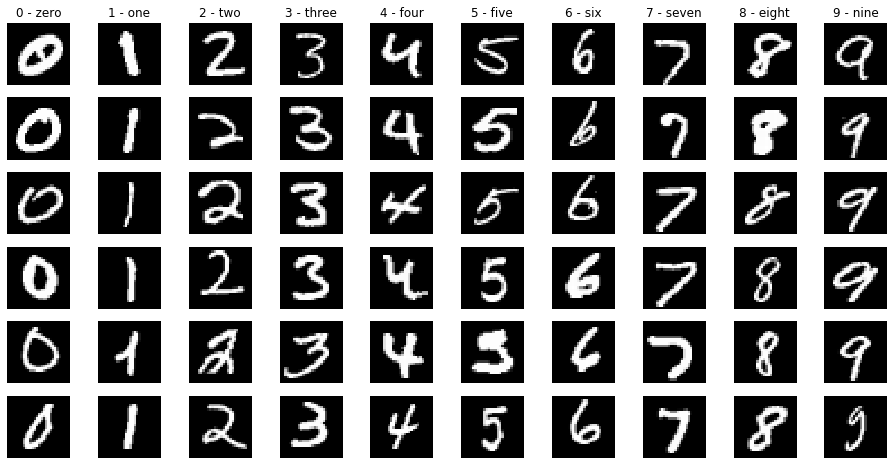

In [0]:
labels = train_dataset.classes
fig = plt.figure(figsize=(16, 8))
rows = 6

images = {}
for label in range(len(labels)):
    images[label] = []

#find some images for each label    
for x in range(1000):
    rand = np.random.randint(len(train_dataset))
    label = train_dataset[rand][1]
    if len(images[label]) > rows:
        continue
    images[label].append(train_dataset[rand][0][0,:,:])
    
for label in range(len(labels)):
    for row in range(rows):
        image = images[label][row]
        fig.add_subplot(rows, len(labels), row * len(labels) + label + 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        if row == 0:
            plt.title(labels[label])
plt.show()

### 2) Choose appropriate hyperparameters for the training (4 points)

In [0]:
#######################################################################################################
# TODO 2: choose sensible training parameters for DCGAN training. 
# Start with few epochs while you design the network, and increase once you think you have a good setup.
# Since GANs train slowly, you may have to use at quite a few epochs to see good results.
#######################################################################################################
batch_size = 32 
lr = 0.0002
num_epochs = 15

### 3) Implement the generator network (8 points)
The expected output of this GAN should look like this (or better):

<img src="img/DCGAN_MNIST.png" align='left' width="355">
<img src="img/DCGAN_fashionMNIST.png" align='left' width="355">

Implement the **DCGAN Generator** and **Discriminator** networks for an output size of $32\times32$ pixels according to the given network diagrams. 

<img src="img/DCGAN_generator.png" align='left' width="800">

Create a function to initialize the weights for `nn.Conv2d` and `nn.ConvTranspose2d` layers with a custom distribution. To that end, complete the function `normal_init`, which initialized the weights of the given pytorch layer with a Normal distribution centered around $mean$ and a standard deviation $std$.

##### Hint: 
`summary` from the `torchsummary` package is a very helpful tool to inspect the layers in your network. Use it like so:

```
M = MyNetwork()
M.cuda()
summary(M, input_size=myExpectedInputSize)
```

In [0]:
#######################################################################################################
# TODO 3a: implement a function that initializes the layer's weights with mean and standard deviation.
#######################################################################################################

def normal_init(layer, mean, std):
  nn.init.normal_(layer, mean, std).to(device)

In [0]:
#######################################################################################################
# TODO 3b: implement the generator network for a DCGAN with output size 32x32px
#######################################################################################################
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),


            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )

    # forward method
    def forward(self, input):
        return self.network(input)
    
    # weight_init
    def weight_init(self, mean, std):
        self.network.apply(normal_init)
Generator()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

### 4) Implement the discriminator network (8 points)
<img src="img/DCGAN_discriminator.png" align='left' width="800">

In [0]:
#######################################################################################################
# TODO 3c: implement the discriminator network for a DCGAN with input size 32x32px
#######################################################################################################
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 3, 1),
            nn.Sigmoid()
        )
    # forward method
    def forward(self, input):
        return self.network(input)
    
    # weight_init
    def weight_init(self, mean, std):
      self.network.apply(normal_init)
Discriminator()

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
    (10): Sigmoid()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


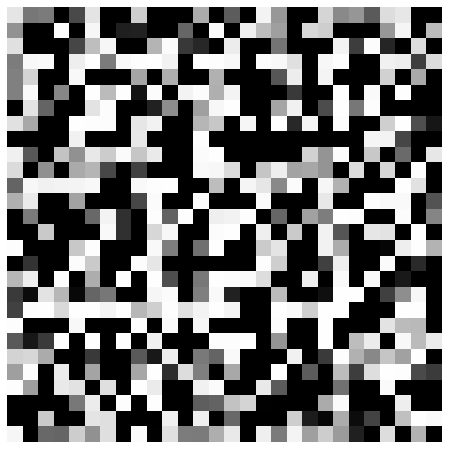

In [0]:
grid_size = 6

#######################################################################################################
# TODO 4: generate a fixed noise vector to repeatedly evaluate the output of the generator 
# with the same noise vector as training progresses
#######################################################################################################
fixed_z = torch.randn(1, 100, 1, 1).to(device)

# output generated samples from the current state of the generator network
def show_result(num_epoch, show=False, save=False, grid_size=6, path = 'result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z).cpu()
        else:
            # TODO generate a new random noise vector
            z = torch.randn(1, 100, 1, 1).to(device)
            fake = G(z).cpu()

        fig, ax = plt.subplots(figsize=(8, 8))
        
        image = utils.make_grid(fake.data, grid_size, 1)
        
        plt.imshow(np.transpose(image, (1, 2, 0)))    
        ax.axis('off')
        plt.savefig(path)
        if show:
            plt.show()
        else:
            plt.close()

# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
G = Generator().to(device)
show_result( 0, show=True, path=' ', useFixed=False )

### 5) Training Setup (5 points) and Training Loop (10 points)

Instantiate a Generator and a Discriminator network, move networks to GPU and initialize the weights of their convolutional layers with $\mu=0$ and $\sigma=0.02$.

Create an ADAM optimizer for the generator as well as the discriminator with your chosen learning rate. Use $\beta_1=0.5$ and $\beta_2=0.999$ as described in Section 4 of the paper.

In the training loop, evaluate the output of the generator network on a random latent vector of length 100. Then, evaluate the performance of the discriminator on the generated images as well as the real image minibatch. Assign the real results the label $1$ (`torch.ones`) and the fake results the label $0$ (`torch.zeros`), then calculate the losses for each of these steps using Binary Cross Entropy loss.
        

#### Hint:
If you would like to load a stored model for additional training or for evaluation, you can do it the following way:
```
M = MyNetwork() #instantiate the network
checkpoint = torch.load("path_to_stored_network.pkl")
M.load_state_dict(checkpoint)
M.eval()
``` 

*If your model fails to train properly, include the failure cases into your report, explain what you think went wrong, and try again!*

Training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1 / 20] G loss: 3.2878429889678955 D loss: 0.6735537648200989


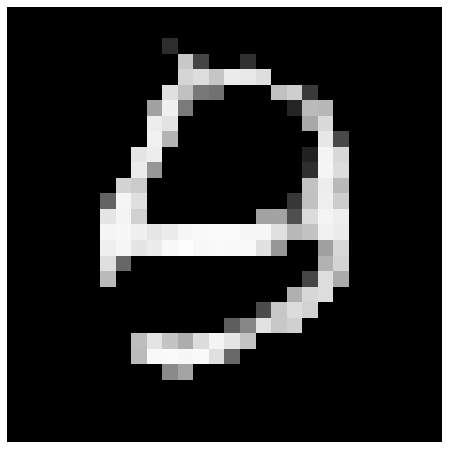

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2 / 20] G loss: 3.162753105163574 D loss: 0.7851129174232483


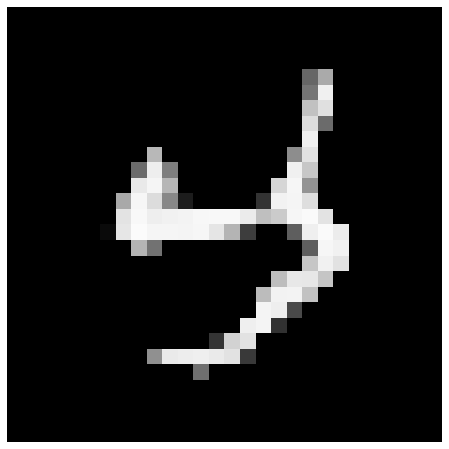

KeyboardInterrupt: ignored

In [0]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dset_name = 'mnist' #pick a meaningful name
result_dir = '{}_DCGAN'.format(dset_name)



#######################################################################################################
# TODO 5a: Fill code for training setup
#######################################################################################################

# define networks
G = Generator().to(device)
D = Discriminator().to(device)
# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# calculate the losses for each of these steps using Binary Cross Entropy loss.
loss = nn.BCELoss()
num_epochs = 20

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(result_dir+'/Random'):
    os.mkdir(result_dir+'/Random')
if not os.path.isdir(result_dir+'/Fixed'):
    os.mkdir(result_dir+'/Fixed')

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    for real, _ in data_loader:
        real = real.to(device)
        batch_size = real.size(0)

        #######################################################################################################
        # TODO 5b: Fill code for training loop
        #######################################################################################################
        
        # generate random latent vector z and real and fake labels 
        z =  torch.randn(batch_size, 100, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        real_labels = torch.ones(batch_size).to(device)

        # generate fakes  
        fakes = G(z)

        # evaluate fakes
        fake_pred = D(fakes).view(-1)

        fake_loss = loss(fake_pred, fake_labels)

        # evaluate real minibatch
        real_pred = D(real).view(-1)
        real_loss = loss(real_pred, real_labels)

        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = fake_loss + real_loss

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()    
        
        # train generator to output an image that is classified as real   
        fakes = G(z)
        # evaluate fakes
        fake_pred = D(fakes).view(-1)
        G_train_loss = loss(fake_pred, real_labels)  
        
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              


        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_result( epoch, save=True, path=result_dir + '/Random/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=False )
    show_result( epoch, save=True, show=True, path=result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)

end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot the loss curves    
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# Visualize the training progress as an animated GIF
images = []
for e in range(num_epochs):
    img_name = result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/DCGAN_generation_animation.gif', images, fps=5)

In [0]:
result_dir + '/DCGAN_generation_animation.gif'

### Display the animated generation GIF

% **TODO: edit path to GIF** %

<img src='full_path_to_gif.gif' width="512">

### 6) Explore the latent space of the generator (5 points)
We now want to **explore the expressiveness** of the Generator. Intuitively, a small change in values of the latent vector $z$ should result in a small change in the output image, and a linear interpolation between two latent vectors $z_1$ and $z_2$ should yield a reasonably smooth transition from one valid output image to another. Implement a function that creates a grid of latent vectors, where each row is an interpolation from the leftmost to the rightmost latent vector, with $n$ interpolation steps.

The expected output of this function should look like this (or better): 


<img src="img/latent_space_morph_MNIST.png" width="900">
<img src="img/latent_space_morph_fashionMNIST.png" width="900">

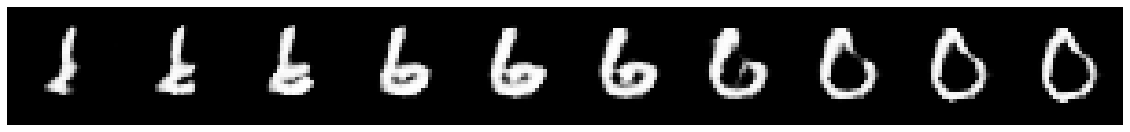

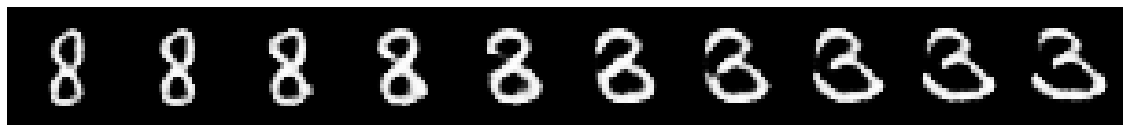

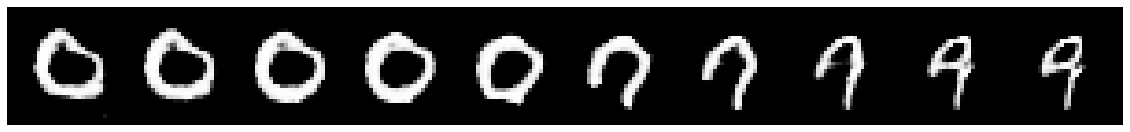

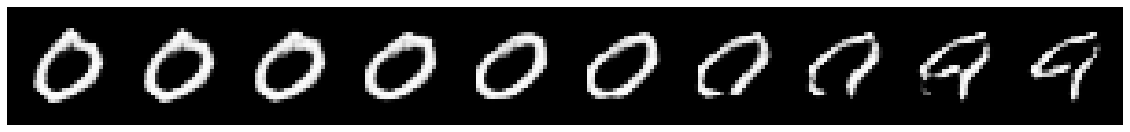

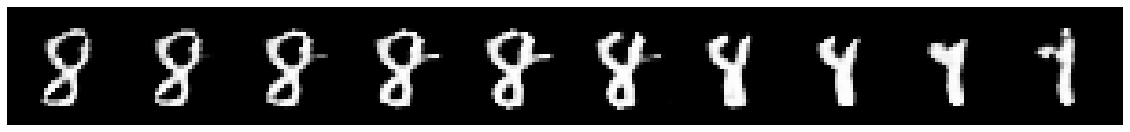

In [0]:
def generate_latent_interpolation(rows=5, interp_steps=10):
     with torch.no_grad():
        #######################################################################################################
        # TODO 6: for each row, create interpolation between leftmost and rightmost output image
        #######################################################################################################
        
        for r in range(rows):
          p1,p2 =  torch.randn(1, 100, 1, 1), torch.randn(1, 100, 1, 1)
          interpolation = [np.array((1.0 - r) * p1 + r * p2) for r in np.linspace(0, 1, num=interp_steps)]
          interpolation = torch.FloatTensor(interpolation).view(10,100,1,1).to(device)
          X = G(interpolation).cpu()
          grid_images = (X + 1) / 2.0
          
          fig, ax = plt.subplots(figsize=(20, 10))
          grid = utils.make_grid(grid_images, interp_steps)
          plt.imshow(np.transpose(grid, (1, 2, 0)))
          ax.axis('off')

generate_latent_interpolation()        

### 7) Modify the network to output $64\times64$ RGB images (10 points)

Download `UTK_face.tar.gz` from [Google Drive](https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE) and extract the images to your working directory in the folder `./data/UTKFace/train`. This dataset [4] contains approximately 24K cropped images of human faces of mixed age, gender and race.

Load these images and resize them to the dimensions you want to generate ($64\times64$ RGB images). Replicate and modify your Generator and Discriminator network architectures in order to output the appropriate image size and three color channels. You may want to consult the [original DCGAN paper](https://arxiv.org/abs/1511.06434) to check what their suggested architecture looks like. You should generate an output similar to this (or better):

<img src="img/DCGAN_faces.png" width="900">



You can either modify the code above, or copy the necessary code pieces, but **make sure you include all results** of different datasets in your final report or in this notebook.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#######################################################################################################
# TODO 7: resize the images such that they have the shape of 3x64x64
#######################################################################################################

train_dataset = torchvision.datasets.ImageFolder(
    root='./data/UTKFace'
    , transform=transforms.Compose([
                           transforms.Resize((64,64), interpolation=2),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                           
    ])
)
print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  11169
Image size: torch.Size([3, 64, 64])
value range: [ -0.9921568632125854 - 0.9607843160629272 ]


In [0]:
#######################################################################################################
# TODO 3b: implement the generator network for a DCGAN with output size 64x64px
#######################################################################################################
#######################################################################################################
# TODO 3b: implement the generator network for a DCGAN with output size 32x32px
#######################################################################################################
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),


            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
    # forward method
    def forward(self, input):
        return self.network(input)
    
    # weight_init
    def weight_init(self, mean, std):
        self.network.apply(normal_init)
Generator()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [0]:
#######################################################################################################
# TODO 3c: implement the discriminator network for a DCGAN with input size 64x64px
#######################################################################################################
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 4),
            nn.Sigmoid()
        )
    # forward method
    def forward(self, input):
        return self.network(input)
    
    # weight_init
    def weight_init(self, mean, std):
      self.network.apply(normal_init)
Discriminator()
        

Discriminator(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

In [0]:
#######################################################################################################
# TODO 7: train a DCGAN on the face images
#######################################################################################################

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dset_name = 'UTKFace' #pick a meaningful name
result_dir = '{}_DCGAN'.format(dset_name)



#######################################################################################################
# TODO 5a: Fill code for training setup
#######################################################################################################

# define networks
G = Generator().to(device)
D = Discriminator().to(device)
# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# calculate the losses for each of these steps using Binary Cross Entropy loss.
loss = nn.BCELoss()
num_epochs = 30

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(result_dir+'/Random'):
    os.mkdir(result_dir+'/Random')
if not os.path.isdir(result_dir+'/Fixed'):
    os.mkdir(result_dir+'/Fixed')

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    for real, _ in data_loader:
        real = real.to(device)
        batch_size = real.size(0)

        #######################################################################################################
        # TODO 5b: Fill code for training loop
        #######################################################################################################
        
        # generate random latent vector z and real and fake labels 
        z =  torch.randn(batch_size, 100, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        real_labels = torch.ones(batch_size).to(device)

        # generate fakes  
        fakes = G(z)
        #print(fakes.size())
        # evaluate fakes
        fake_pred = D(fakes).view(-1)
        #print(fake_pred.size())
        fake_loss = loss(fake_pred, fake_labels)

        # evaluate real minibatch
        real_pred = D(real).view(-1)
        #print(real_pred.size())
        real_loss = loss(real_pred, real_labels)

        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = fake_loss + real_loss

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()    
        
        # train generator to output an image that is classified as real   
        fakes = G(z)
        # evaluate fakes
        fake_pred = D(fakes).view(-1)
        G_train_loss = loss(fake_pred, real_labels)  
        
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              


        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_result( epoch, save=True, path=result_dir + '/Random/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=False )
    show_result( epoch, save=True, show=True, path=result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)

end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot the loss curves    
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# Visualize the training progress as an animated GIF
images = []
for e in range(num_epochs):
    img_name = result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/DCGAN_generation_animation.gif', images, fps=5)



Training ...


KeyboardInterrupt: ignored

### 8) Create a latent space walk of the Face Generator you trained (5 points)
To that end, generate as many random latents as your animation has number of frames. Then, use a gaussian filter on those latents in order to create a smooth blending between adjacent frames in the animation. Have a look at `scipy.ndimage.gaussian_filter` for that purpose. Make sure that your animation can loop endlessly, i.e. the last frames and the first frames of the animation also blend. The $\sigma$ value of the gaussian filter defines how many frames are blended; use the given parameter values of the function to control this value.<br>
Your output should look like this (or better):

<img src='img/Faces_DCGAN_latent_walk_1.gif' style='margin: 0px 10px' align='left' width="128">

<img src='img/Faces_DCGAN_latent_walk_2.gif' style='margin: 0px 10px' align='left' width="128">

<img src='img/Faces_DCGAN_latent_walk_3.gif' style='margin: 0px 10px' align='left' width="128">

In [0]:
def generate_latent_walk(duration_sec=20.0, smoothing_sec=1.0, fps=30):
    #######################################################################################################
    # TODO 8: create a smoothly interpolated loop through random latent space values
    #######################################################################################################
    
    images = None #TODO create smoothly interpolating images
    
    imageio.mimsave(result_dir + '/latent_space_walk.gif', images, fps=fps)

#generate_latent_walk()       

## Assignment 4B: Conditional DCGAN

Our previous Generator network was generating random outputs for each input latent vector without any measure of control over the output. 
Now, we would like to add some control mechanism such that we can determine the class for a generated image, e.g. generate only the number $5$ or images from the category $Shirt$.

The expected output of this GAN should look like this (or better):

<img src="img/cond_DCGAN_MNIST.png" align='left' width="550">
<img src="img/cond_DCGAN_fashionMNIST.png" align='left' width="550">

For simplicity, we will use either _MNIST_ or _FashionMNIST_ at $32\times32$ grayscale for this exercise again.

For a class-conditioned output, we need to modify both the generator as well as the discriminator network to accept a class label as part of the input. These labels need to be transformed from a "categorical" input to a numerical vector. Use `torch.nn.Embedding` to transform the label to such an embedding space.

### 8) Modify Networks for conditional GANs (4 points)

Select appropriate training hyperparameters.

In [0]:
# TODO: choose reasonable values
batch_size = 32
num_epochs = 10
learning_rate = 0.0002

### 9) Design a conditional discriminator network (8 points)

Below diagrams shows the architecture that you're expected to implement

<img src="img/DCGAN_discriminator_conditional.png" align='left' width="900">

In [0]:
#######################################################################################################
#TODO 9: update the discriminator network to incorporate the label input
#######################################################################################################    
class Discriminator(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 128, 4, 2, 1)
        self.conv1_1_bn = nn.BatchNorm2d(128)
        
        self.conv1_2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv1_2_bn = nn.BatchNorm2d(256)
        
        self.emb = nn.Embedding(num_embeddings=n_classes, embedding_dim=50)
        self.lin = nn.Linear(50,64)
        
        self.conv2 = nn.Conv2d(257, 512, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(512)
    
        self.conv3 = nn.Conv2d(512, 1, 4, 1, 0)
    
    def forward(self, input, labels):
        x = F.leaky_relu(self.conv1_1_bn(self.conv1_1(input)), 0.2)
        x = F.leaky_relu(self.conv1_2_bn(self.conv1_2(x)), 0.2)

        
        l = self.emb(labels)
        l = self.lin(l).view(-1,1,8,8)
        x = torch.cat([x, l], 1)

        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.sigmoid(self.conv3(x))
        return x
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

### 8) Design a conditional generator network (8 points)

<img src="img/DCGAN_generator_conditional.png" align='left' width="900">

In [0]:
#######################################################################################################
#TODO 10: update the generator network to incorporate the label input
#######################################################################################################
class Generator(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, 512, 4)
        self.deconv1_1_bn = nn.BatchNorm2d(512)
        
        self.deconv1_2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.deconv1_2_bn = nn.BatchNorm2d(256)
        
        self.emb = nn.Embedding(num_embeddings=n_classes, embedding_dim=50)
        self.lin = nn.Linear(50,64)
            
        self.deconv2 = nn.ConvTranspose2d(257, 128, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 1, 4, 2, 1)
    
    def forward(self, input, labels):
        # TODO implement forward pass  
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        x = F.relu(self.deconv1_2_bn(self.deconv1_2(x)))


        l = self.emb(labels)
        l = self.lin(l).view(-1,1,8,8)
        x = torch.cat([x, l], 1)
        
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.tanh(self.deconv3(x))
        #print(x.size())
        return x
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            

#### Complete the output function (5 points)

In [0]:
def generate_z_with_labels():
    
    fixed_z = full_z = torch.rand(1, 100, 1, 1).to(device)
    fixed_labels = torch.arange(10).to(device)
    z_labels = (torch.rand(batch_size, 1) * 10).type(torch.LongTensor).squeeze().to(device)
    
    for i in range(9):
        full_z = torch.cat([full_z, fixed_z], 0)
        
    return full_z, fixed_labels

# output generated samples from the current state of the generator network
n_samples = 5

fixed_z, fixed_labels = generate_z_with_labels()
    
def show_conditional_result(num_epoch, show=False, save=False, n_classes=10, n_samples=5, path='result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z, fixed_labels).cpu()
        else:
            z, labels = generate_z_with_labels()
            fake = G(z, labels).cpu()

        fig, ax = plt.subplots(figsize=(20, 10))
        image = utils.make_grid(fake.data, n_classes, 1)

        plt.imshow(np.transpose(image, (1, 2, 0)))

        ax.axis('off')

        plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


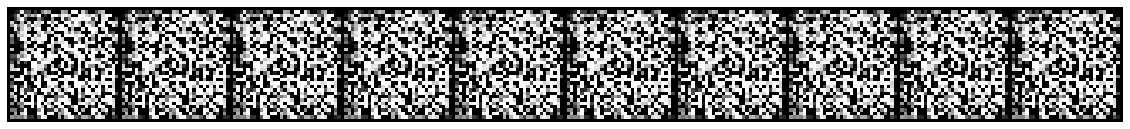

In [0]:
# output generated samples from the current state of the generator network
n_samples = 5

#######################################################################################################
# TODO 11: generate a fixed noise vector and a fixed set of labels to evaluate the output of the generator
# with the same noise parameters as training progresses.
# Arrange the labels into a grid to show same label outputs in the same column (see example results above) 
#######################################################################################################

def show_conditional_result(num_epoch, show=False, save=False, n_classes=10, n_samples=5, path='result.png', useFixed=True):
    with torch.no_grad():
        fixed_z = torch.randn(1, 100, 1, 1).to(device)
        labels = torch.arange(10).to(device)
        fixed_labels = torch.arange(10).to(device)
        z = [fixed_z for i in range(10)]
        z = torch.cat(z, 0)
        if useFixed:   
            fake = G(z, labels).cpu()
        else:
            # TODO generate a new random noise vector and a grid of labels
            fixed_z = torch.randn(1, 100, 1, 1).to(device)
            labels = torch.arange(10).to(device)
            fixed_labels = torch.arange(10).to(device)
            z = [fixed_z for i in range(10)]
            z = torch.cat(z, 0)

            fake = G(z, labels).cpu()
            #print(D(fake, labels).view(-1))
        fig, ax = plt.subplots(figsize=(20, 10))
        image = utils.make_grid(fake.data, n_classes, 1)

        plt.imshow(np.transpose(image, (1, 2, 0)))

        ax.axis('off')

        plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()   
# define networks
G = Generator().to(device)
D = Discriminator().to(device)
show_conditional_result(-1, show=True)

#### Complete the training setup (5 points) and training loop (10 points)

In [0]:
train_dataset = datasets.MNIST('./data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32,32), interpolation=2),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ]))

print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  60000
Image size: torch.Size([1, 32, 32])
value range: [ -1.0 - 0.9843137264251709 ]


Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1 / 30] G loss: 5.318337917327881 D loss: 0.04498403146862984


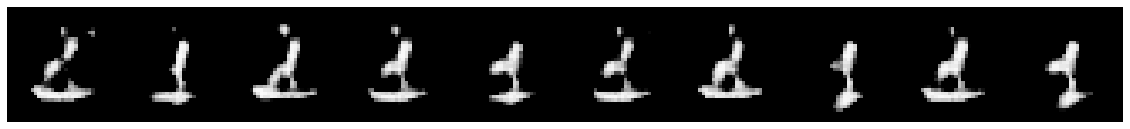

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=32x32 at 0x7F377189CA58>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 585, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2 / 30] G loss: 4.901525497436523 D loss: 0.016367752104997635


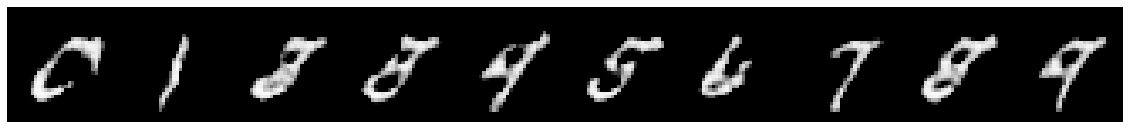

In [0]:
plt.ion()

# define dataloader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

result_dir = '{}_conditional_DCGAN'.format(dset_name)

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
    

#######################################################################################################
# TODO 12: define training setup
#######################################################################################################

# TODO define networks
G = Generator().to(device)
D = Discriminator().to(device)

# TODO define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    num_batches = 0
    
    for real, labels in data_loader:
        
        real = real.to(device)
        batch_size = real.size(0)
        labels= labels.to(device)
        #######################################################################################################
        # TODO 13: Fill code for training loop
        #######################################################################################################

        # generate random latent vector z and random class assignments for each generated image in the minibatch as well as real and fake labels 
        z =  torch.randn(batch_size, 100, 1, 1).to(device)
        random_labels = torch.LongTensor(batch_size).random_(0, 10).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        real_labels = torch.ones(batch_size).to(device)
        
        # generate fakes    
        fakes = G(z, random_labels) 
        
        # evaluate fakes
        fake_pred = D(fakes, random_labels).view(-1)
        fake_loss = loss(fake_pred, fake_labels)
        # evaluate real minibatch
        real_pred = D(real, labels).view(-1)
        real_loss = loss(real_pred, real_labels)
        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = fake_loss + real_loss      

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()  

        # train generator to output an image that is classified as real
        fakes = G(z, random_labels)
        fake_pred = D(fakes, random_labels).view(-1)
        G_train_loss = loss(fake_pred, real_labels)    
        
        
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())
        
        epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_conditional_result( epoch, save=True, show=True, path=result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)
     
end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot loss curves
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# show training progress as animation
images = []
for e in range(num_epochs):
    img_name = result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/conditional_DCGAN_generation_animation.gif', images, fps=5)

### Display the animated generation GIF

% **TODO: edit path to GIF** %

<img src='full_path_to_gif.gif' width="512">